In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from matplotlib import style
from scipy.stats import norm

# Styles
style.use('fivethirtyeight')
plt.rcParams['figure.facecolor'] = '#FFFFFF'
plt.rcParams['font.family'] = 'Georgia'
plt.rcParams['font.size'] = 18

In [2]:
# Functions
#https://dfrieds.com/data-visualizations/how-format-large-tick-values.html

def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

In [3]:
# Load Data
dfs = pd.read_csv('../../Datos/LQI/20m/raw_data_run1--28.csv', 
                       index_col ='Date', 
                       parse_dates = True) 

cantidad=len(dfs)
print(cantidad)

# Split data into train / test sets 
#Hallar el 75% y el 25%
entrenamiento = int((cantidad/100)*75)
testing = int((cantidad/100)*25)
print(entrenamiento, testing)

#datos de entrenamiento y testing sin Walk Forward Validation 75% y 25%
df=dfs[:entrenamiento]
sales = df['LQI']

test=dfs[entrenamiento:cantidad]
test=test.reset_index(drop="true")

8064
6048 2016


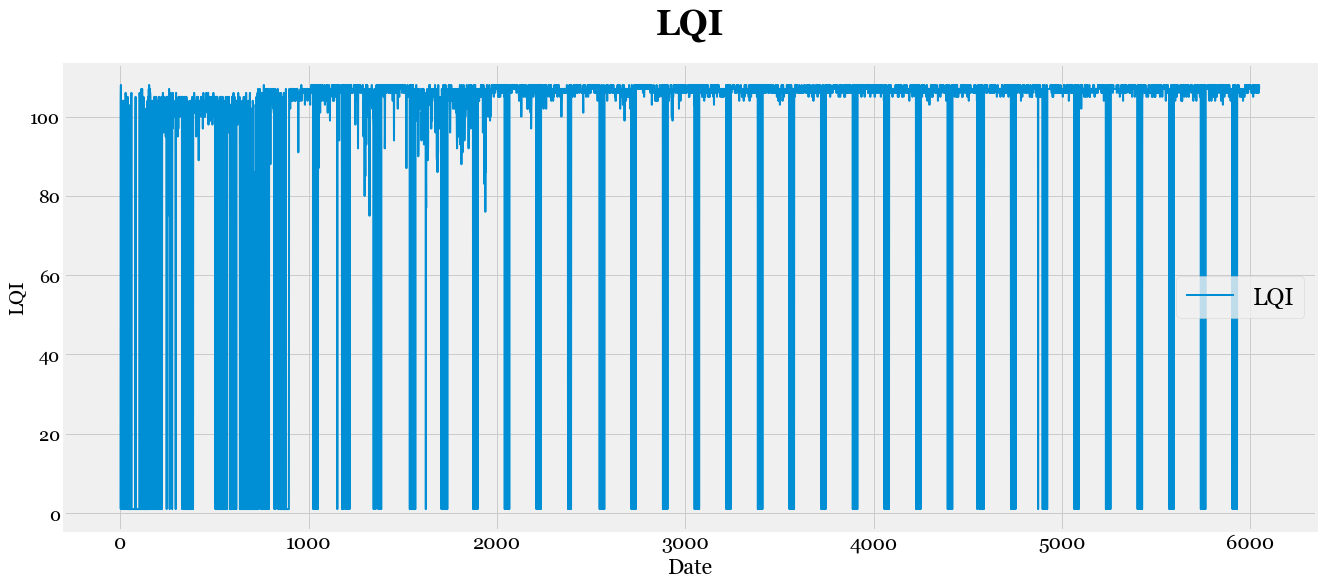

In [4]:
# Sales
smoothed = sales.rolling(window=6).mean()
smoothed = smoothed.dropna()

fig, ax = plt.subplots(figsize=(20,8))

ax.set_title('LQI', fontsize=35, fontweight='bold', pad=30)
ax.set_ylabel('LQI', fontsize=20)
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

for t in ax.xaxis.get_major_ticks():
    t.label.set_fontsize(20) 

df['LQI'].plot(ax=ax, linewidth=2, label="LQI")
ax.legend(fontsize=24)

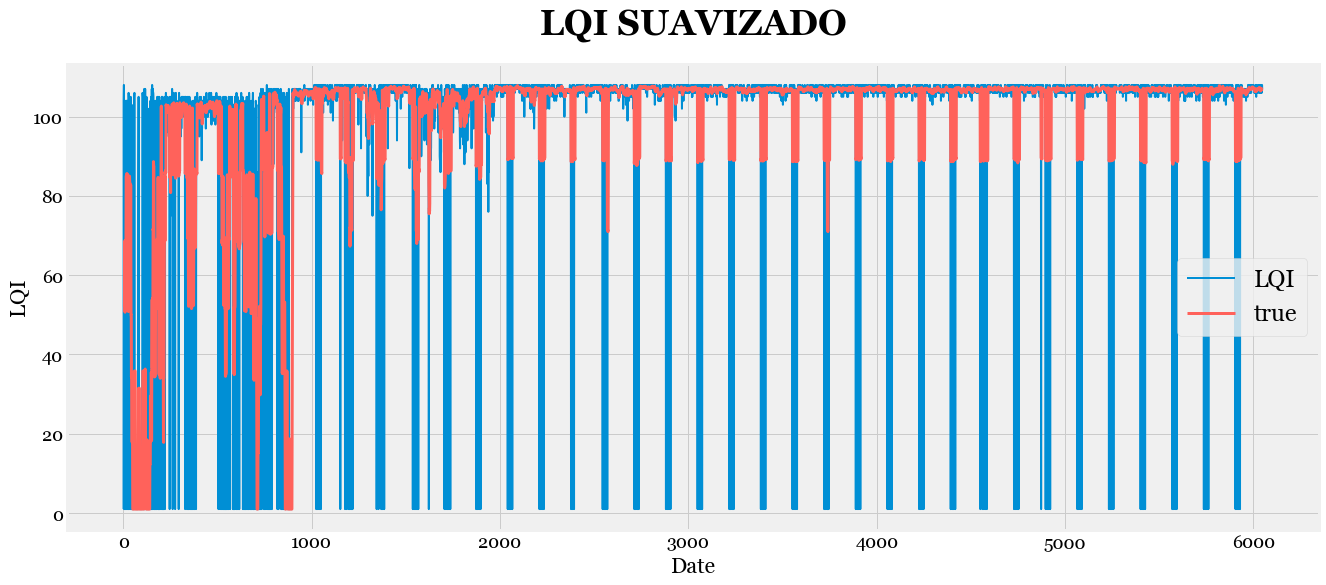

In [5]:
# Total Sales with Smoothing
smoothed = sales.rolling(window=6).mean()
smoothed = smoothed.dropna()

fig, ax = plt.subplots(figsize=(20,8))

ax.set_title('LQI SUAVIZADO', fontsize=35, fontweight='bold', pad=30)
ax.set_ylabel('LQI')
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

sales.plot(ax=ax, linewidth=2, label="LQI")
smoothed.plot(ax=ax, linewidth=3, color='#FF625B', label="true")

ax.legend(fontsize=24)

Text(0.5, 1.0, 'Distribution of groups of 30')

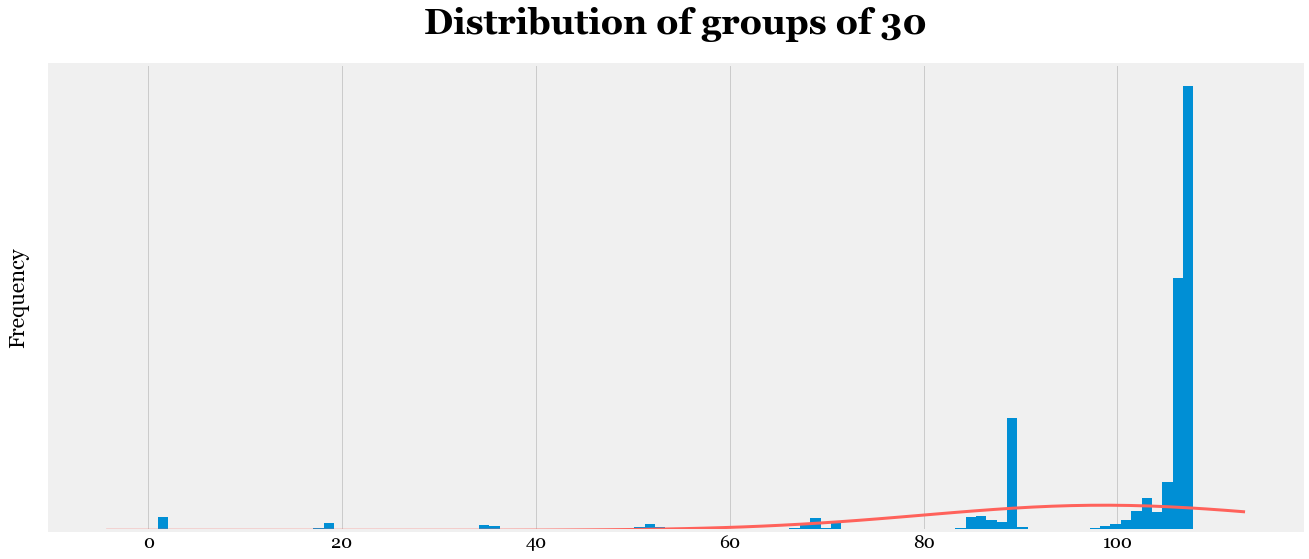

In [6]:
# Distribution of Weekly Sales
fig, ax = plt.subplots(figsize=(20,8))

smoothed.plot.hist(bins=100, density=True, ax=ax)

# Plot the pdf
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 60)
p = norm.pdf(x, smoothed.mean(), smoothed.std())
ax.plot(x, p, color='#FF625B', linewidth=3)
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

ax.set_yticks([])
ax.set_ylabel('Frequency', labelpad=20)
ax.set_title('Distribution of groups of 30', fontsize=35, fontweight='bold', pad=30)

In [7]:
smoothed

Date
6        52.000000
7        68.666667
8        68.500000
9        50.666667
10       67.500000
           ...    
6044    107.000000
6045    106.833333
6046    107.000000
6047    107.000000
6048    107.000000
Name: LQI, Length: 6043, dtype: float64

In [8]:
smoothed[entrenamiento-1]

107.0

Text(0.5, 1.05, 'Simulate Random Walks')

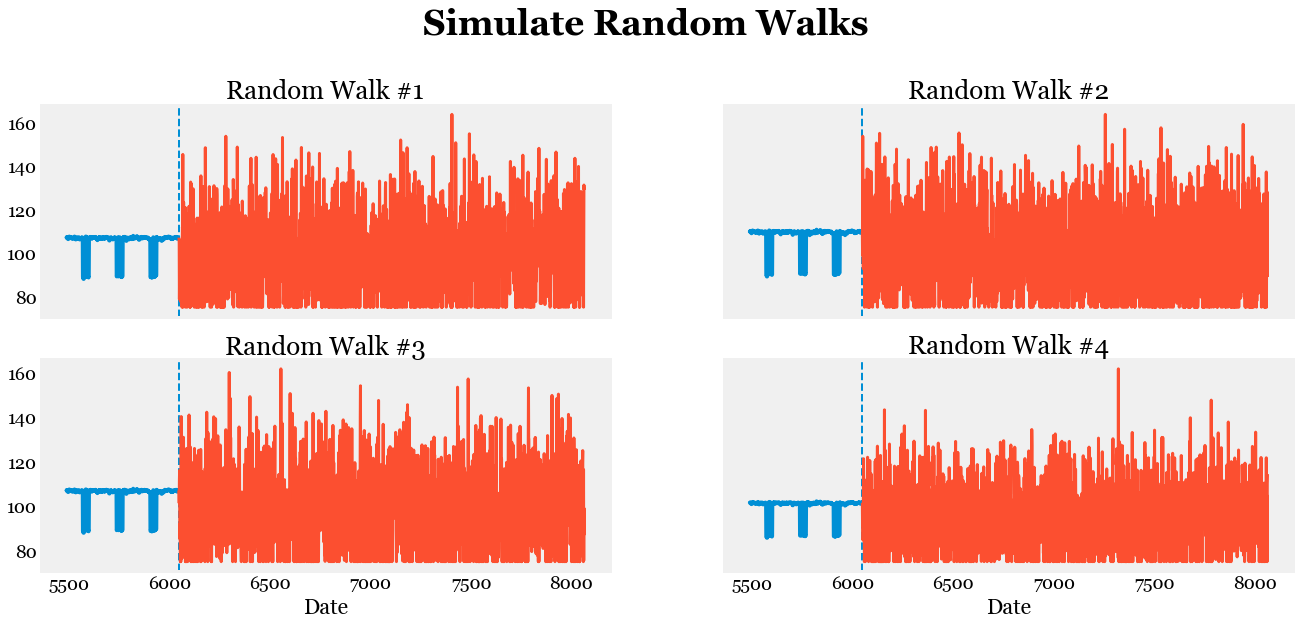

In [9]:
# A random walk
last_sale = smoothed[entrenamiento-1]
num_weeks = testing

mu = smoothed.mean()
std = smoothed.std()

index = range(entrenamiento-1,cantidad)

def make_sim_plot(ax=ax, title=''):
    sales_series = []
    sales_series.append(last_sale)

    for week in range(num_weeks):
        weekly_sales = np.random.normal(mu, std)
        if weekly_sales < 75:
            weekly_sales = 75;
        sales_series.append(weekly_sales)
    s = pd.Series(sales_series, index=index)
    ax.set_title(title)
    ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
    ax.axvline(x=s.index.min(), linestyle='dashed', linewidth=2)

    smoothed[-562:].plot(ax=ax)
    s.plot(ax=ax, linewidth=3)

    
fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(2,2, figsize=(20,8))

make_sim_plot(ax1, title='Random Walk #1')
make_sim_plot(ax2, title='Random Walk #2')
make_sim_plot(ax3, title='Random Walk #3')
make_sim_plot(ax4, title='Random Walk #4')
ax2.set_yticks([])
ax4.set_yticks([])
ax2.set_xticks([])
ax2.set_xlabel('')
ax1.set_xticks([])
ax1.set_xlabel('')

ax1.grid(None)
ax2.grid(None)
ax3.grid(None)
ax4.grid(None)

fig.suptitle('Simulate Random Walks', fontsize=35, fontweight='bold', y=1.05)

In [10]:
num_simulations = 50000  #n simulaciones*************

# Creating an array, 
price_list = np.zeros((testing,num_simulations))
price_list[0]=smoothed[entrenamiento-1]
price_list

array([[107., 107., 107., ..., 107., 107., 107.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [11]:
price_list[0,0]

107.0

Text(0.5, 0.98, 'Simulations of 1,000 Random Walks')

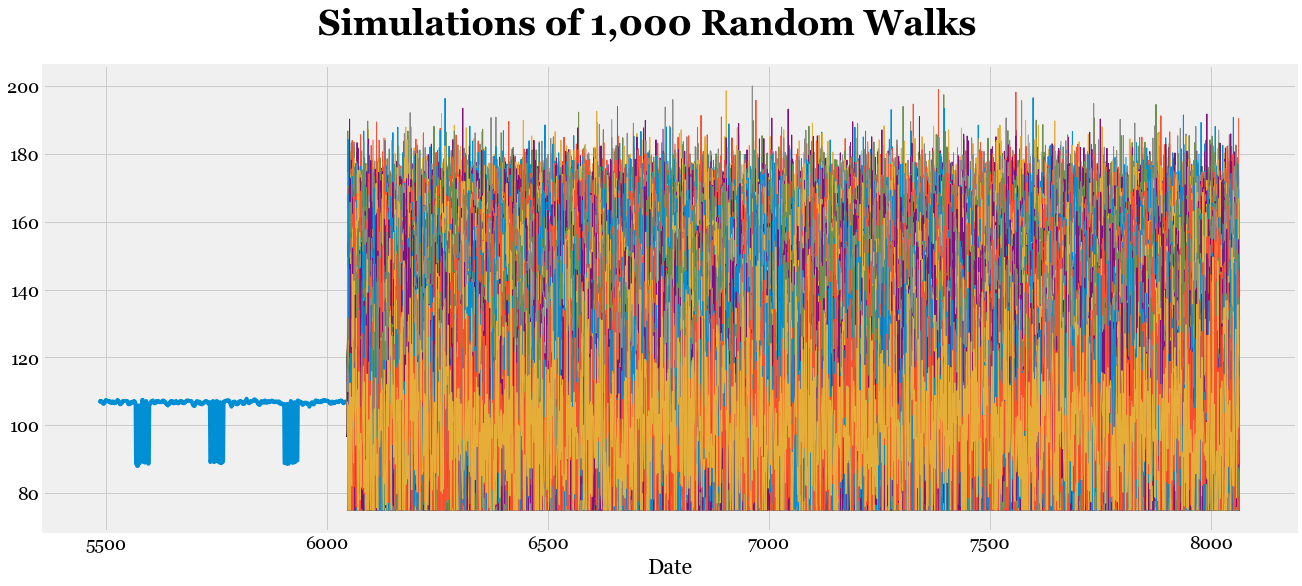

In [12]:
# Many, many random walks
num_simulations = 50000   #n simulaciones**********
iterations=num_simulations
num_weeks = testing

last_sale = smoothed[entrenamiento-1]
mu = smoothed.mean()
std = smoothed.std()

index = range(entrenamiento-1,cantidad)

simulation_df = pd.DataFrame()


sales_2018 = []

for sim in range(num_simulations):
    sales_series = []
    sales_series.append(last_sale)

    for week in range(num_weeks):
        weekly_sales = np.random.normal(mu, std)
        if weekly_sales < 75:
            weekly_sales = 75
        #aprovechar el for de semanas para llenar una matriz con las predicciones
        price_list[week,sim]=weekly_sales;
        #print( price_list[week,sim]);
        sales_series.append(weekly_sales)
    
    sales_2018.append(np.sum(sales_series))
    
    simulation_df[sim] = sales_series
    

simulation_df.index = index


fig, ax = plt.subplots(figsize=(20,8))
smoothed[-562:].plot(ax=ax)
simulation_df.plot(ax=ax, legend=False, linewidth=1)

ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
fig.suptitle('Simulations of 1,000 Random Walks', fontsize=35, fontweight='bold')

In [13]:
print(price_list)

[[ 99.76143795  96.91439595 104.73746567 ...  76.10100486  98.47563955
   84.98526283]
 [154.90242214  77.37760728 106.49683461 ... 100.85951693  88.91267656
   75.        ]
 [ 87.57670866  84.76822554  82.88832565 ...  84.08497203  85.01940854
  106.03524819]
 ...
 [106.57886424 107.70656202  92.78360875 ...  92.72765523  88.43130204
  135.5196432 ]
 [ 91.4568412   92.54137423  75.         ... 108.81917095  88.79360296
  113.37120879]
 [106.69545753  99.94392239 112.99818191 ... 120.47500993 114.14678832
   99.33816598]]


Text(0.5, 0.98, 'Total LQI FORECAST')

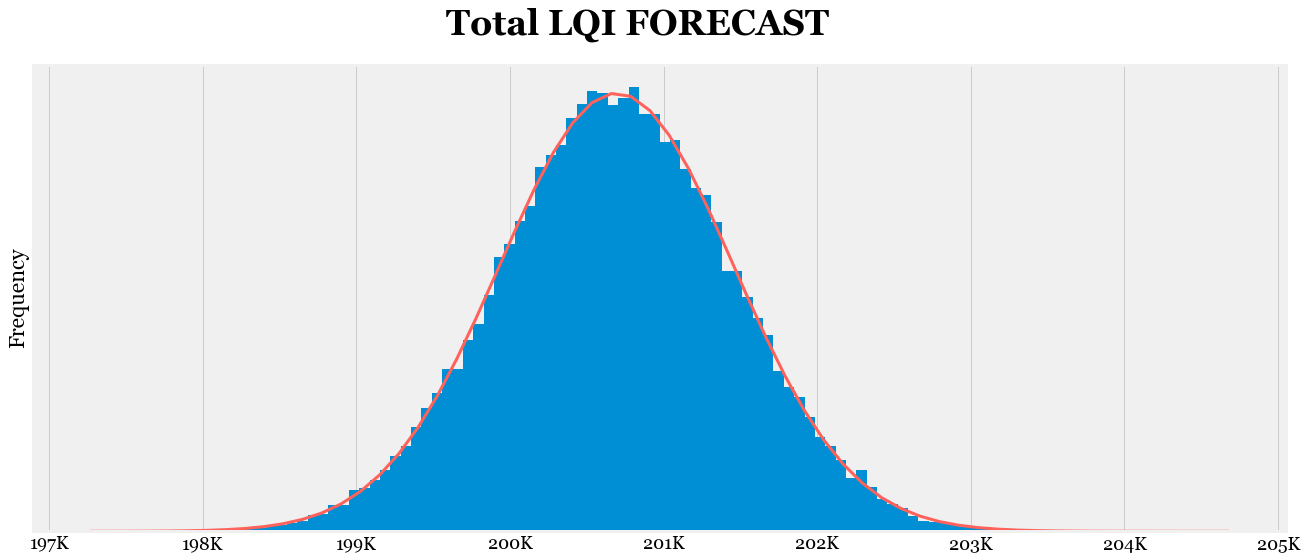

In [14]:
#Random walk total sales

fig, ax = plt.subplots(figsize=(20,8))
simulations_2018 = pd.Series(data=sales_2018)
simulations_2018.plot.hist(bins=100, ax=ax, density=True)

# Plot the pdf
xmin, xmax = plt.xlim()
mean = simulations_2018.mean()
std = simulations_2018.std()

x = np.linspace(xmin, xmax, 60)
p = norm.pdf(x, mean, std)
ax.plot(x, p, color='#FF625B', linewidth=3)
ax.set_yticks([])
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
fig.suptitle('Total LQI FORECAST', fontsize=35, fontweight='bold')

Text(0.5, 0.98, 'TOTAL LQI FORECAST Normal Distribution')

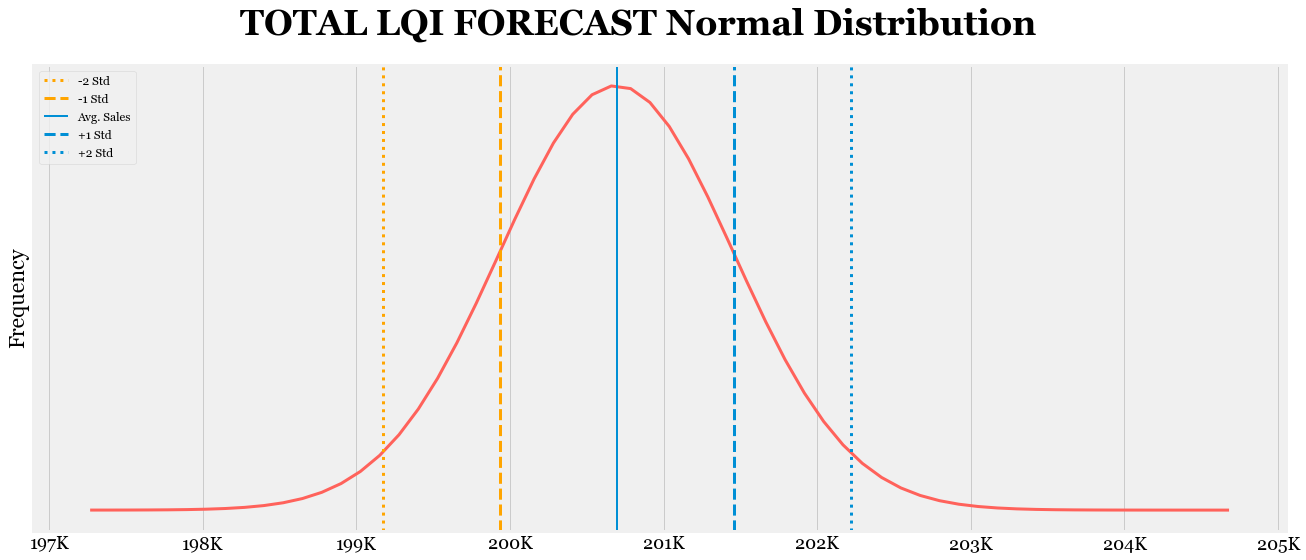

In [15]:
# 2018 Sales normal distribution
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(x, p, color='#FF625B', linewidth=3)

ax.set_yticks([])
ax.set_ylabel('Frequency')

ax.axvline(mean - (std * 2), linewidth=3, label='-2 Std', linestyle='dotted', color='orange')
ax.axvline(mean - std, linewidth=3, label='-1 Std', linestyle='dashed', color='orange')
ax.axvline(mean, linewidth=2, label="Avg. Sales")
ax.axvline(mean + std, linewidth=3, label='+1 Std', linestyle='dashed')
ax.axvline(mean + (std * 2), linewidth=3, label='+2 Std', linestyle='dotted')

ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
ax.legend(fontsize=12, loc='upper left')
fig.suptitle('TOTAL LQI FORECAST Normal Distribution', fontsize=35, fontweight='bold')

In [16]:
# Ask Questions

from scipy.stats import norm
#mean + std * norm.
#mean + (std * norm.ppf(.25))
print("It's highly likely that you LQI will be between ${:,.0f} and ${:,.0f}.".format(mean + (2 * -std), mean + (2 * std)))
print("There's a 25% chance that LQI will be less than {:,.0f}.".format(mean + (std * norm.ppf(.25))))

It's highly likely that you LQI will be between $199,171 and $202,217.
There's a 25% chance that LQI will be less than 200,180.


In [17]:
simulation_df

,0,1,2,3,4,5,6,7,8,9,...,49990,49991,49992,49993,49994,49995,49996,49997,49998,49999
6047,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,...,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000
6048,99.761438,96.914396,104.737466,83.135213,85.324351,82.864279,75.000000,75.000000,75.000000,122.272198,...,88.783432,114.184573,97.089118,75.000000,128.809056,116.582874,109.713310,76.101005,98.475640,84.985263
6049,154.902422,77.377607,106.496835,116.434240,83.148658,112.248789,75.000000,106.026543,99.899986,111.839410,...,85.657766,101.135139,75.026000,124.969816,75.157515,89.200073,75.000000,100.859517,88.912677,75.000000
6050,87.576709,84.768226,82.888326,85.352786,95.326625,87.213680,120.678391,93.377529,79.796446,85.286284,...,113.586469,105.413647,104.700511,119.801073,116.996571,91.038500,84.422173,84.084972,85.019409,106.035248
6051,136.495665,86.897481,75.000000,88.843969,102.191664,101.476445,82.516118,75.000000,105.770903,107.391630,...,111.567847,92.078419,85.581156,98.380482,117.927880,115.228833,85.121826,94.718027,75.000000,97.650350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8059,87.536573,99.398624,139.365362,126.960032,75.000000,85.475977,101.165819,81.036114,97.810968,87.766443,...,106.161751,92.751104,120.171229,86.352896,101.850992,128.272173,93.988393,122.239806,79.034692,105.405048
8060,116.899158,131.496917,98.380881,75.000000,93.592291,118.234747,132.803350,86.149578,99.112964,92.352588,...,95.212969,105.640323,76.546280,86.320046,124.122772,90.796246,96.329020,89.357662,101.942071,95.739706
8061,106.578864,107.706562,92.783609,124.358913,128.980333,79.973365,110.739188,117.846152,77.263183,102.416380,...,95.194211,92.963216,75.000000,107.840449,78.668971,95.834475,91.919478,92.727655,88.431302,135.519643
8062,91.456841,92.541374,75.000000,113.782718,141.356878,104.916285,95.440812,75.000000,104.188748,75.000000,...,98.773856,84.455900,100.851429,96.132894,88.965061,94.190294,98.805501,108.819171,88.793603,113.371209


In [18]:
print(test)
test

      LQI
0     107
1     106
2     108
3     107
4     108
...   ...
2011  103
2012  104
2013  100
2014  104
2015  103

[2016 rows x 1 columns]


,LQI
0,107
1,106
2,108
3,107
4,108
...,...
2011,103
2012,104
2013,100
2014,104


In [19]:
#HALLLAR LA MEJOR SIMULACIÓN MEDIANTE RMSE Y plotearla con una cantidad de datos de test

# Load specific evaluation tools 
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 

#for para comparar todas las predicciones

menor=30;
index=0;

for i in range(0, iterations):
    prediction = rmse(test["LQI"], price_list[:, i]) 
    if prediction<menor:
        menor=prediction
        index=i
        
        
print(menor, index)
    


22.68068671473468 16994


In [20]:
# Load specific evaluation tools 
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 


#métricas
prediction1 = price_list[:, index];
rmse(test["LQI"], prediction1) 


# Calculate mean squared error 
mse = mean_squared_error(test["LQI"], prediction1)
print("MSE: ")
print(mse)

# Calculate root mean squared error 
rmse = rmse(test["LQI"], prediction1)
print("\nRMSE: ")
print(rmse)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape =  mean_absolute_percentage_error(test["LQI"], prediction1)
print("\nMAPE (Porcentaje): ")
print(mape)

MSE: 
514.4135498519422

RMSE: 
22.68068671473468

MAPE (Porcentaje): 
245.79917634716938


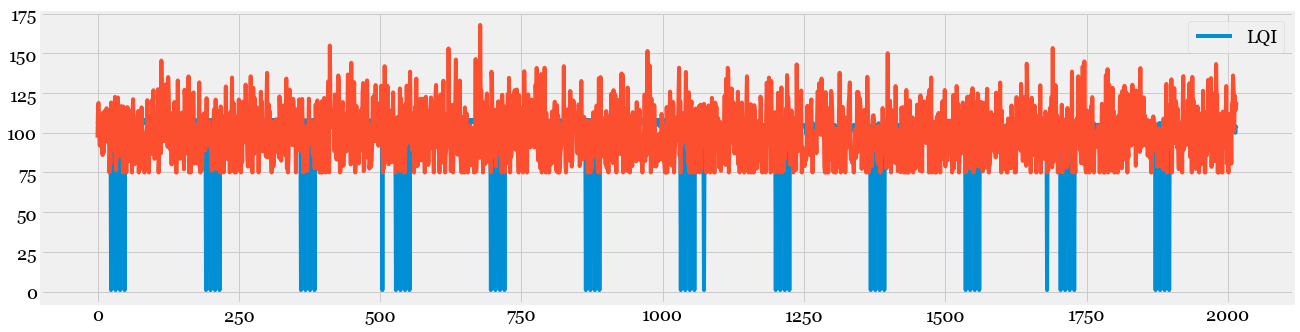

In [21]:
bp = price_list[:,index];

test.plot(figsize = (20, 5), label="true");
plt.plot(bp, label="forecast");